In [71]:
import requests
import zipfile
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly import express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams
from matplotlib import font_manager
simpsonfont = "simpsonfont/Simpsonfont DEMO.ttf"

In [2]:
# Define URLs
urls = {
    "characters": "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-02-04/simpsons_characters.csv",
    "episodes": "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-02-04/simpsons_episodes.csv",
    "locations": "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-02-04/simpsons_locations.csv",
    "script_lines": "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-02-04/simpsons_script_lines.csv",
}

# Load CSVs into pandas DataFrames
simpsons_characters = pd.read_csv(urls["characters"])
simpsons_episodes = pd.read_csv(urls["episodes"])
simpsons_locations = pd.read_csv(urls["locations"])
simpsons_script_lines = pd.read_csv(urls["script_lines"])

# Check structure (equivalent to `glimpse()` in R)
print(simpsons_characters.info())
print(simpsons_episodes.info())
print(simpsons_locations.info())
print(simpsons_script_lines.info())

# _____________________________________________________________________________
# Filtering Data: Keep only episodes from 2010 onwards
# _____________________________________________________________________________

# Convert air year to integer if needed
simpsons_episodes["original_air_year"] = pd.to_numeric(simpsons_episodes["original_air_year"], errors="coerce")

# Filter episodes to include only 2010+
simpsons_episodes = simpsons_episodes[simpsons_episodes["original_air_year"] >= 2010]

# Filter script lines to only include lines for these episodes
simpsons_script_lines = simpsons_script_lines[
    simpsons_script_lines["episode_id"].isin(simpsons_episodes["id"])
]

# Output final dataset shapes
print(f"Filtered episodes: {simpsons_episodes.shape}")
print(f"Filtered script lines: {simpsons_script_lines.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               6722 non-null   int64 
 1   name             6722 non-null   object
 2   normalized_name  6722 non-null   object
 3   gender           323 non-null    object
dtypes: int64(1), object(3)
memory usage: 210.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      151 non-null    int64  
 1   image_url               148 non-null    object 
 2   imdb_rating             148 non-null    float64
 3   imdb_votes              148 non-null    float64
 4   number_in_season        151 non-null    int64  
 5   number_in_series        151 non-null    int64  
 6   original_air_date       151 non-n

In [4]:
simpsons_episodes.isna().sum()

id                        0
image_url                 3
imdb_rating               3
imdb_votes                3
number_in_season          0
number_in_series          0
original_air_date         0
original_air_year         0
production_code           0
season                    0
title                     0
us_viewers_in_millions    3
video_url                 3
views                     3
dtype: int64

In [7]:
simpsons_episodes[simpsons_episodes['us_viewers_in_millions'].isna()]

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
52,598,NaN,NaN,NaN,2,598,2016-10-02,2016,VABF18,28,"Friends and Family""[203]",NaN,NaN,NaN
53,599,NaN,NaN,NaN,3,599,2016-10-09,2016,VABF17,28,"The Town""[205]",NaN,NaN,NaN
54,600,NaN,NaN,NaN,4,600,2016-10-16,2016,VABF16,28,"Treehouse of Horror XXVII""[207]",NaN,NaN,NaN


In [8]:
simpsons_episodes_filtered = simpsons_episodes.copy(deep=True)

In [9]:
simpsons_episodes_filtered = simpsons_episodes.dropna(subset = ['us_viewers_in_millions'])

In [10]:
simpsons_episodes_filtered

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
0,450,http://static-media.fxx.com/img/FX_Networks_-_...,6.8,481.0,9,450,2010-01-03,2010,MABF02,21,Thursdays with Abie,8.65,http://www.simpsonsworld.com/video/250369603964,36227.0
1,452,http://static-media.fxx.com/img/FX_Networks_-_...,7.1,532.0,11,452,2010-01-31,2010,MABF03,21,Million Dollar Maybe,5.11,http://www.simpsonsworld.com/video/279804995696,40854.0
2,455,http://static-media.fxx.com/img/FX_Networks_-_...,7.1,480.0,14,455,2010-03-14,2010,MABF04,21,Postcards from the Wedge,5.23,http://www.simpsonsworld.com/video/250390595937,41357.0
3,457,http://static-media.fxx.com/img/FX_Networks_-_...,5.7,675.0,16,457,2010-03-28,2010,MABF10,21,The Greatest Story Ever D'ohed,5.69,http://www.simpsonsworld.com/video/279809091713,44070.0
4,462,http://static-media.fxx.com/img/FX_Networks_-_...,6.9,491.0,21,462,2010-05-09,2010,MABF13,21,Moe Letter Blues,5.66,http://www.simpsonsworld.com/video/250592323527,40904.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,500,http://static-media.fxx.com/img/FX_Networks_-_...,7.0,580.0,14,500,2012-02-19,2012,PABF07,23,At Long Last Leave,5.77,http://www.simpsonsworld.com/video/230541891832,45226.0
147,502,http://static-media.fxx.com/img/FX_Networks_-_...,7.3,541.0,16,502,2012-03-11,2012,PABF08,23,How I Wet Your Mother,4.97,http://www.simpsonsworld.com/video/230597187582,44818.0
148,511,http://static-media.fxx.com/img/FX_Networks_-_...,6.9,460.0,3,511,2012-11-04,2012,PABF18,24,Adventures in Baby-Getting,5.65,http://www.simpsonsworld.com/video/221688899646,39687.0
149,542,http://static-media.fxx.com/img/FX_Networks_-_...,6.4,473.0,12,542,2014-03-09,2014,SABF08,25,Diggs,2.69,http://www.simpsonsworld.com/video/310529091639,39292.0


In [11]:
simpsons_episodes_filtered[simpsons_episodes_filtered['us_viewers_in_millions'].isna()]

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views


In [ ]:
simpsons_episodes_filtered.columns

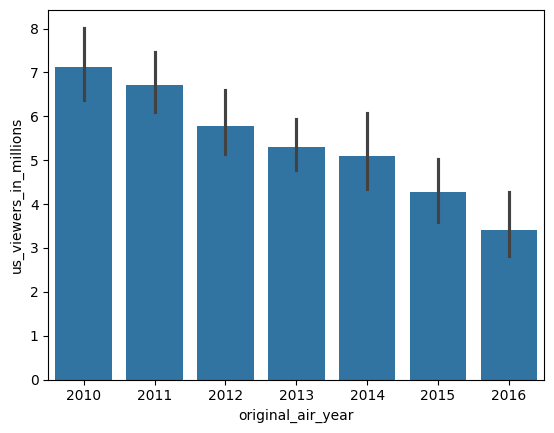

In [12]:
sns.barplot(data = simpsons_episodes_filtered, x = 'original_air_year', y = 'us_viewers_in_millions')
plt.show()

In [13]:
simpsons_episodes_filtered['air_date_formatted'] = pd.to_datetime(simpsons_episodes_filtered['original_air_date'])

/var/folders/l7/dn0hll995195kvrl49_9xmp40000gn/T/ipykernel_69292/2774574900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simpsons_episodes_filtered['air_date_formatted'] = pd.to_datetime(simpsons_episodes_filtered['original_air_date'])


In [14]:
simpsons_episodes_filtered['week_of_the_year'] = simpsons_episodes_filtered['air_date_formatted'].dt.isocalendar().week

/var/folders/l7/dn0hll995195kvrl49_9xmp40000gn/T/ipykernel_69292/4258543870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simpsons_episodes_filtered['week_of_the_year'] = simpsons_episodes_filtered['air_date_formatted'].dt.isocalendar().week


In [15]:
simpsons_episodes_filtered['week_of_the_year'] = simpsons_episodes_filtered['week_of_the_year'].apply(lambda x: 1 if x == 53 else x)

/var/folders/l7/dn0hll995195kvrl49_9xmp40000gn/T/ipykernel_69292/425177160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simpsons_episodes_filtered['week_of_the_year'] = simpsons_episodes_filtered['week_of_the_year'].apply(lambda x: 1 if x == 53 else x)


In [16]:
simpsons_episodes_filtered['season'].value_counts()

season
22    22
23    22
24    22
25    22
26    22
27    22
21    15
28     1
Name: count, dtype: int64

In [17]:
simpsons_episodes_filtered[simpsons_episodes_filtered['season'] == 28]

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views,air_date_formatted,week_of_the_year
144,597,http://static-media.fxx.com/img/FX_Networks_-_...,6.6,104.0,1,597,2016-09-25,2016,VABF20,28,Monty Burns' Fleeing Circus,3.36,http://www.simpsonsworld.com/video/772654659902,994.0,2016-09-25,38


In [18]:
simpsons_episodes_filtered = simpsons_episodes_filtered.query('season != 28')

In [19]:
simpsons_episodes_filtered['season'].value_counts()

season
22    22
23    22
24    22
25    22
26    22
27    22
21    15
Name: count, dtype: int64

In [20]:
existing_weeks = set(simpsons_episodes_filtered['week_of_the_year'])
full_weeks = set(range(1, 53))

missing_weeks = full_weeks.difference(existing_weeks)

missing_weeks = [*missing_weeks]

missing_weeks

[5,
 8,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 51,
 52]

In [22]:
simpsons_episodes_filtered_2 = simpsons_episodes_filtered.copy(deep = True)

simpsons_episodes_filtered_2.loc[:, 'week_of_the_year'] = simpsons_episodes_filtered['week_of_the_year'].astype('category')

In [23]:
tv_season_week_order = list(range(38, 53)) + list(range(1, 38))

In [26]:
simpsons_episodes_filtered_2["week_of_the_year"] = simpsons_episodes_filtered_2["week_of_the_year"].astype(str)

In [27]:
simpsons_episodes_filtered_2["season"] = simpsons_episodes_filtered_2["season"].astype('category')

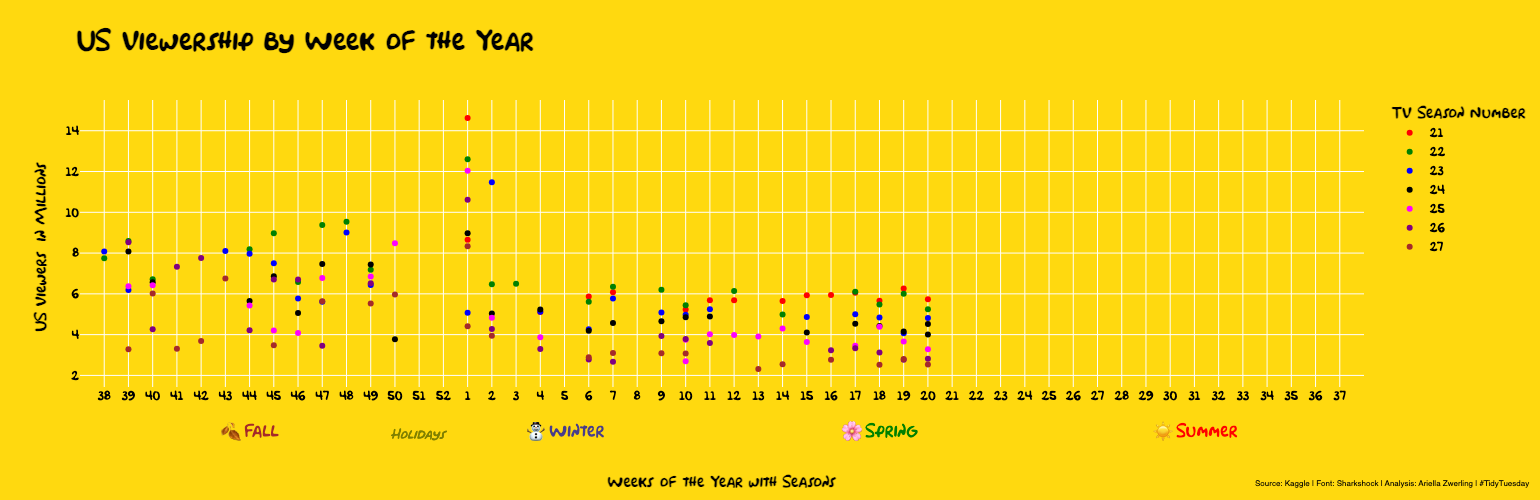

In [72]:
tv_season_week_order = list(range(38, 53)) + list(range(1, 38))

fig = px.scatter(simpsons_episodes_filtered_2, 
                 x="week_of_the_year", 
                 y="us_viewers_in_millions",
                 color="season",
                 color_discrete_sequence=["red", "green", "blue", "black", "magenta", 'purple', 'brown'],
                 labels={
                     "week_of_the_year": "<b>Weeks  of  the  Year  with  Seasons</b>",
                     "us_viewers_in_millions": "<b>US  Viewers  (in  Millions)</b>",
                     "season": "<b>TV  Season  Number</b>"
                 },
                title="<b>US  Viewership  by  Week  of  the  Year</b>")

fig.update_layout(
    width=1500,
    height = 500,
    paper_bgcolor='rgb(255,217,15)',
    plot_bgcolor='rgb(255,217,15)',
    title=dict(
        font=dict(
            family='simpsonfont',
            size=25,
            color='black'
    )),
    font_family="simpsonfont",
    font_color="black",
    legend_title_font_color="black",
    xaxis=dict(range=[min(tv_season_week_order) - 2, max(tv_season_week_order)],
               title_standoff=75),
    xaxis_automargin=True,
)

fig.update_xaxes(categoryorder='array', categoryarray=[str(w) for w in tv_season_week_order])

fig.add_annotation(x="6", y=-0.20, text="🍂 Fall", showarrow=False, font=dict(size=16, color="brown"), yref="paper")
fig.add_annotation(x="19", y=-0.20, text="⛄ Winter", showarrow=False, font=dict(size=16, color="darkslateblue"), yref="paper")
fig.add_annotation(x="13", y=-0.20, text="<i>Holidays</i>", showarrow=False, font=dict(size=12, color="olive"), yref="paper")
fig.add_annotation(x="32", y=-0.20, text="🌸 Spring", showarrow=False, font=dict(size=16, color="green"), yref="paper")
fig.add_annotation(x="45", y=-0.20, text="☀️ Summer", showarrow=False, font=dict(size=16, color="red"), yref="paper")

fig.add_annotation(
    text="Source: Kaggle | Font: Sharkshock | Analysis: Ariella Zwerling | #TidyTuesday",
    xref="paper", yref="paper",
    font_family='Helvetica',
    x=1.13, y=-0.36,
    showarrow=False,
    font=dict(size=8)
)

fig.show()


In [29]:
week_views = pd.DataFrame(simpsons_episodes_filtered_2.groupby('week_of_the_year')['us_viewers_in_millions'].mean().reset_index())

In [30]:
week_views["week_of_the_year"] = pd.Categorical(
    week_views["week_of_the_year"], 
    categories=[str(w) for w in tv_season_week_order], 
    ordered=True
)

In [31]:
week_views = week_views.sort_values('week_of_the_year', ascending = True)

In [32]:
week_views["rolling_avg"] = week_views["us_viewers_in_millions"].rolling(window=3, center=True).mean()

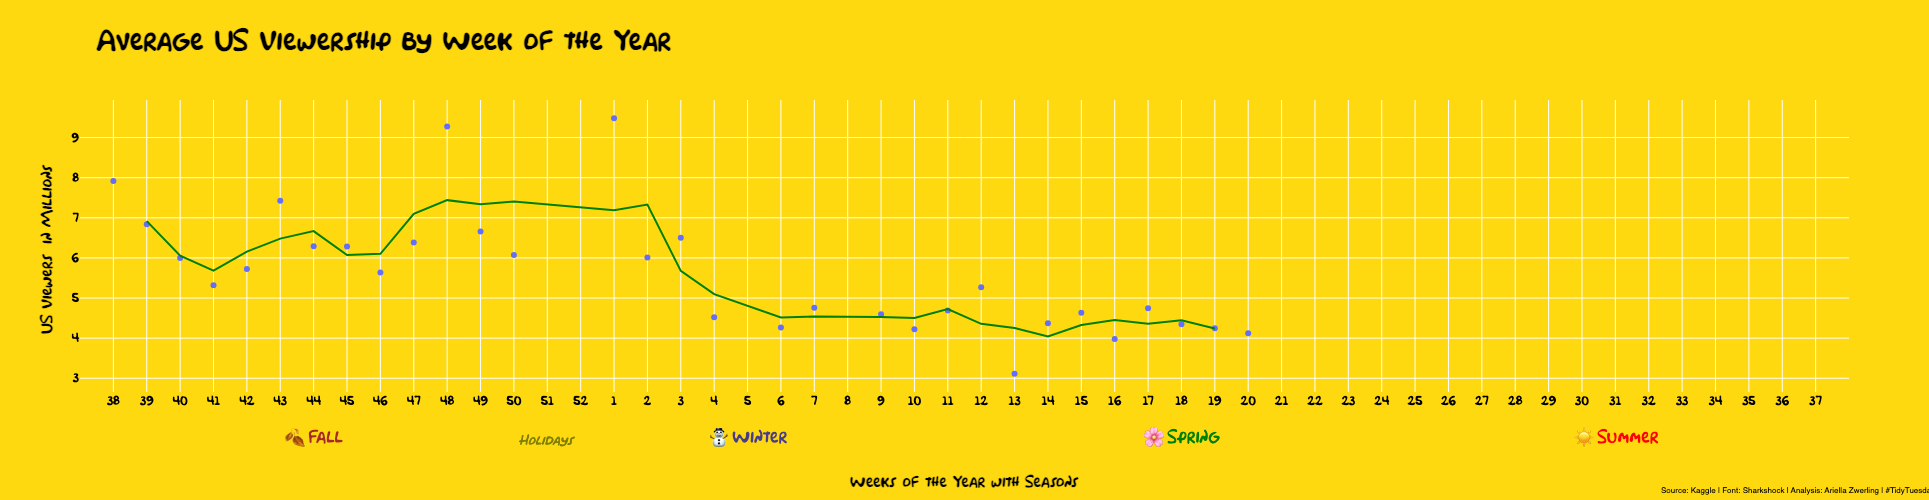

In [70]:
fig = px.scatter(week_views, 
                 x="week_of_the_year", 
                 y="us_viewers_in_millions",
                 # color="season",
                 # color_continuous_scale='jet',
                 labels={
                     "week_of_the_year": "<b>Weeks  of  the  Year  with  Seasons</b>",
                     "us_viewers_in_millions": "<b>US  Viewers  (in  Millions)</b>",
                 },
                title="<b>Average  US  Viewership  by  Week  of  the  Year</b>")

fig.update_layout(
    width=1500,
    height = 500,
    paper_bgcolor='rgb(255,217,15)',
    plot_bgcolor='rgb(255,217,15)',
    title=dict(
        font=dict(
            family='simpsonfont',
            size=25,
            color='black'
    )),
    font_family="simpsonfont",
    font_color="black",
    # legend_title_font_color="black",
    xaxis=dict(range=[min(tv_season_week_order) - 2, max(tv_season_week_order)],
               # side="bottom", 
               title_standoff=70),
    xaxis_automargin=True,
)

fig.update_xaxes(categoryorder='array', categoryarray=[str(w) for w in tv_season_week_order])

rolling_trace = px.line(week_views, x="week_of_the_year", y="rolling_avg").data[0]
rolling_trace.line.color = "green"
rolling_trace.line.width = 2

fig.add_trace(rolling_trace)

fig.add_annotation(x="6", y=-0.20, text="🍂 Fall", showarrow=False, font=dict(size=16, color="brown"), yref="paper")
fig.add_annotation(x="19", y=-0.20, text="⛄ Winter", showarrow=False, font=dict(size=16, color="darkslateblue"), yref="paper")
fig.add_annotation(x="13", y=-0.20, text="<i>Holidays</i>", showarrow=False, font=dict(size=12, color="olive"), yref="paper")
fig.add_annotation(x="32", y=-0.20, text="🌸 Spring", showarrow=False, font=dict(size=16, color="green"), yref="paper")
fig.add_annotation(x="45", y=-0.20, text="☀️ Summer", showarrow=False, font=dict(size=16, color="red"), yref="paper")

fig.add_annotation(
    text="Source: Kaggle | Font: Sharkshock | Analysis: Ariella Zwerling | #TidyTuesday",
    xref="paper", yref="paper",
    font_family='Helvetica',
    x=1.05, y=-0.36,
    showarrow=False,
    font=dict(size=8)
)

fig.show()